🎬 开始执行电影评论情感分析流程


🔍 正在准备停用词列表...
   ✅ 成功加载NLTK英文停用词库
   最终使用停用词数量: 198个
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-wqy-zenhei
0 upgraded, 1 newly installed, 0 to remove and 87 not upgraded.
Need to get 7,472 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Ign:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8
Ign:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8
Ign:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8
Err:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8
  Temporary failure resolving 'archive.ubuntu.com'
E: Failed to fetch http://archive.ubuntu.com/ubuntu/pool/universe/f/fonts-wqy-zenhei/fonts-wqy-zenhei_0.9.45-8_all.deb  Temporary failure resolving 'archive.ubuntu.com'
E: Unable to fetch

/tmp/ipykernel_92/364060481.py:69: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/364060481.py:69: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/364060481.py:69: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/364060481.py:69: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/364060481.py:69: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/364060481.py:69: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/364060481.py:69: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  plt.tight_layout()
/tmp/ipykerne

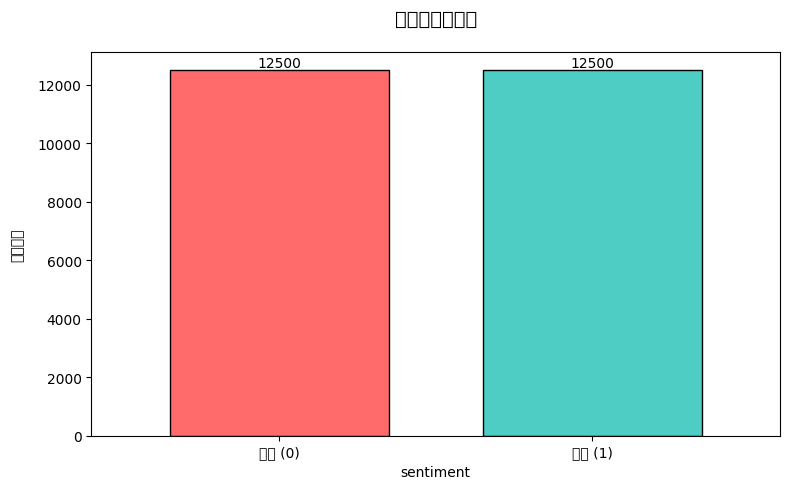


✅ 数据加载完成
训练集: 25000条 | 测试集: 25000条

🛠️ 正在预处理文本...


100%|██████████| 25000/25000 [00:32<00:00, 776.22it/s]



🤖 正在训练模型...

📊 验证集准确率: 89.02%

🎉 分析流程完成！结果已保存为 submission.csv


In [39]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt  # 确保导入matplotlib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
tqdm.pandas()

# ==================== 1. 初始化设置 ====================
print("="*60)
print("🎬 开始执行电影评论情感分析流程")
print("="*60 + "\n")

# ==================== 2. 停用词处理 ====================
def get_stopwords():
    """多级停用词获取方案"""
    print("\n🔍 正在准备停用词列表...")
    try:
        nltk.data.find('corpora/stopwords')
        from nltk.corpus import stopwords
        nltk_stopwords = set(stopwords.words('english'))
        print("   ✅ 成功加载NLTK英文停用词库")
        return nltk_stopwords
    except (LookupError, AttributeError):
        print("   ⚠️ NLTK停用词库未找到，使用精简版停用词")
        return {'i', 'me', 'my', 'myself', 'we', 'our', 'the', 'and', 'is', 'are'}

STOPWORDS = get_stopwords()
print(f"   最终使用停用词数量: {len(STOPWORDS)}个")

# ==================== 3. 数据加载与可视化 ====================
!apt-get install fonts-wqy-zenhei -y

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False

print("\n📂 正在加载数据集...")
train = pd.read_csv("/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip", 
                   sep="\t", quoting=3)
test = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip', 
                 sep="\t", quoting=3)

# 新增情感分布柱状图
plt.figure(figsize=(8, 5))
ax = train['sentiment'].value_counts().plot(
    kind='bar',
    color=['#FF6B6B', '#4ECDC4'],  # 红/青配色
    edgecolor='black',
    width=0.7
)
plt.title("正负面评论分布", fontsize=14, pad=20)
plt.xticks([0, 1], ['负面 (0)', '正面 (1)'], rotation=0)
plt.ylabel("评论数量", labelpad=10)
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()  # 显示图表

print("\n✅ 数据加载完成")
print(f"训练集: {train.shape[0]}条 | 测试集: {test.shape[0]}条")

# ==================== 4. 文本预处理 ====================
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'<[^>]+>', ' ', text)
        text = re.sub(r'http\S+', ' ', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        return ' '.join(text.split())

    def preprocess(self, text):
        cleaned = self.clean_text(text)
        tokens = [self.lemmatizer.lemmatize(w) for w in word_tokenize(cleaned) 
                 if w not in STOPWORDS and len(w) > 2]
        return ' '.join(tokens)

print("\n🛠️ 正在预处理文本...")
preprocessor = TextPreprocessor()
train['processed'] = train['review'].progress_apply(preprocessor.preprocess)
test['processed'] = test['review'].progress_apply(preprocessor.preprocess)

# ==================== 5. 模型训练与评估 ====================
print("\n🤖 正在训练模型...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

X_train, X_val, y_train, y_val = train_test_split(
    train['processed'], train['sentiment'], test_size=0.2, random_state=42
)
pipeline.fit(X_train, y_train)

val_pred = pipeline.predict(X_val)
print("\n📊 验证集准确率: {:.2f}%".format(accuracy_score(y_val, val_pred)*100))

# ==================== 6. 生成预测 ====================
test_pred = pipeline.predict(test['processed'])
submission = pd.DataFrame({
    'id': test['id'],
    'sentiment': test_pred
})
submission.to_csv("submission.csv", index=False)

print("\n" + "="*60)
print("🎉 分析流程完成！结果已保存为 submission.csv")
print("="*60)

🎬 开始执行电影评论情感分析流程


🔍 正在准备停用词列表...
   ✅ 成功加载NLTK英文停用词库

   最终使用停用词数量: 198个
   示例停用词: ['most', 'myself', "haven't", "hasn't", "it's", "i'd", 'who', 'm', 'while', 'being'] ...


📂 正在加载数据集...
   ✅ 数据加载成功

📊 训练集信息:
   - 样本数: 25000
   - 列名: ['id', 'sentiment', 'review']

📊 测试集信息:
   - 样本数: 25000
   - 列名: ['id', 'review']

📈 正在生成数据可视化...


/tmp/ipykernel_92/578186491.py:75: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/578186491.py:75: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/578186491.py:75: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/578186491.py:75: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/578186491.py:75: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/578186491.py:75: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/578186491.py:75: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  plt.tight_layout()
/tmp/ipykerne

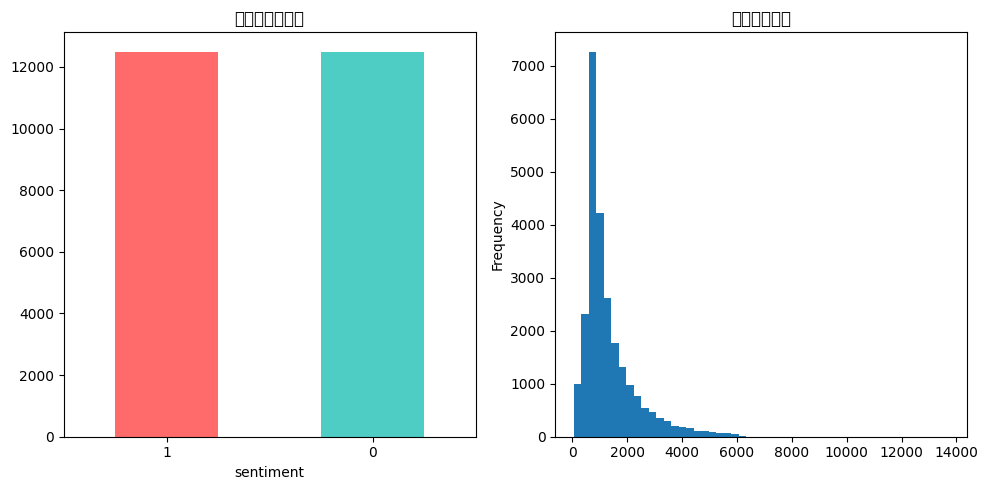


📝 训练集标签分布:
sentiment
1    12500
0    12500
Name: count, dtype: int64

📝 原始评论示例:
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want  ...

🛠️ 开始文本预处理...

🔧 预处理示例:
   原始文本: "With all this stuff going down at the moment with MJ i've started listening to his music, watching  ...
   清洗后: with all this stuff going down at the moment with mj i ve started listening to his music watching th ...
   最终处理: stuff going moment started listening music watching odd documentary watched wiz watched moonwalker m ...

⏳ 正在处理训练集...


100%|██████████| 25000/25000 [00:33<00:00, 746.29it/s]



⏳ 正在处理测试集...


100%|██████████| 25000/25000 [00:32<00:00, 765.76it/s]



✅ 预处理完成
   处理后示例: stuff going moment started listening music watching odd documentary watched wiz watched moonwalker m ...

🤖 正在构建模型管道...

🔧 模型配置:
   - 特征数量: 10,000
   - N-gram范围: (1, 2)
   - 最小文档频率: 5
   - 最大文档频率: 0.7
   - 逻辑回归迭代次数: 1000

⏳ 正在划分训练集/验证集...
   - 训练样本: 20000
   - 验证样本: 5000

⏳ 开始训练模型...
✅ 模型训练完成

📊 正在评估模型...

📝 验证集性能:
   准确率: 0.8906

📋 分类报告:
              precision    recall  f1-score   support

          负面       0.90      0.88      0.89      2481
          正面       0.88      0.90      0.89      2519

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000


🔮 正在生成测试集预测...
   预测完成，正面评论比例: 50.28%

💾 正在保存结果...
✅ 结果已保存为 submission.csv

🎉 分析流程完成！


In [40]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
tqdm.pandas()

# ==================== 1. 初始化设置 ====================
print("="*60)
print("🎬 开始执行电影评论情感分析流程")
print("="*60 + "\n")

# ==================== 2. 停用词处理 ====================
print("\n🔍 正在准备停用词列表...")
try:
    nltk.data.find('corpora/stopwords')
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
    print("   ✅ 成功加载NLTK英文停用词库")
except (LookupError, AttributeError):
    print("   ⚠️ NLTK停用词库未找到，尝试下载...")
    try:
        nltk.download('stopwords', quiet=False)
        from nltk.corpus import stopwords
        STOPWORDS = set(stopwords.words('english'))
        print("   ✅ 成功下载并使用NLTK停用词")
    except:
        print("   ⚠️ 下载失败，使用精简版停用词")
        STOPWORDS = {'i', 'me', 'my', 'myself', 'we', 'our', 'the', 'and', 'is', 'are'}

print(f"\n   最终使用停用词数量: {len(STOPWORDS)}个")
print("   示例停用词:", list(STOPWORDS)[:10], "...\n")

# ==================== 3. 数据加载 ====================
print("\n📂 正在加载数据集...")
try:
    train = pd.read_csv("/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip", sep="\t", quoting=3)
    test = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip', sep="\t", quoting=3)
    print("   ✅ 数据加载成功")
except Exception as e:
    print(f"   ❌ 数据加载失败: {e}")
    raise

print("\n📊 训练集信息:")
print(f"   - 样本数: {train.shape[0]}")
print(f"   - 列名: {train.columns.tolist()}")
print("\n📊 测试集信息:")
print(f"   - 样本数: {test.shape[0]}")
print(f"   - 列名: {test.columns.tolist()}")

# ==================== 4. 数据可视化 ====================
print("\n📈 正在生成数据可视化...")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train['sentiment'].value_counts().plot(
    kind='bar',
    color=['#FF6B6B', '#4ECDC4'],
    title='正负面评论分布'
)
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
train['review'].str.len().plot(
    kind='hist',
    bins=50,
    title='评论长度分布'
)
plt.tight_layout()
plt.show()

print("\n📝 训练集标签分布:")
print(train['sentiment'].value_counts())
print("\n📝 原始评论示例:")
print(train['review'].iloc[0][:200], "...")

# ==================== 5. 文本预处理 ====================
print("\n🛠️ 开始文本预处理...")

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'<[^>]+>', ' ', text)
        text = re.sub(r'http\S+', ' ', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        return ' '.join(text.split())
    
    def preprocess(self, text):
        cleaned = self.clean_text(text)
        tokens = [self.lemmatizer.lemmatize(w) for w in word_tokenize(cleaned) 
                 if w not in STOPWORDS and len(w) > 2]
        return ' '.join(tokens)

preprocessor = TextPreprocessor()

print("\n🔧 预处理示例:")
print("   原始文本:", train['review'].iloc[0][:100], "...")
print("   清洗后:", preprocessor.clean_text(train['review'].iloc[0])[:100], "...")
print("   最终处理:", preprocessor.preprocess(train['review'].iloc[0])[:100], "...")

print("\n⏳ 正在处理训练集...")
train['processed'] = train['review'].progress_apply(preprocessor.preprocess)
print("\n⏳ 正在处理测试集...")
test['processed'] = test['review'].progress_apply(preprocessor.preprocess)

print("\n✅ 预处理完成")
print("   处理后示例:", train['processed'].iloc[0][:100], "...")

# ==================== 6. 模型训练 ====================
print("\n🤖 正在构建模型管道...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.7
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))
])

print("\n🔧 模型配置:")
print("   - 特征数量: 10,000")
print("   - N-gram范围: (1, 2)")
print("   - 最小文档频率: 5")
print("   - 最大文档频率: 0.7")
print("   - 逻辑回归迭代次数: 1000")

print("\n⏳ 正在划分训练集/验证集...")
X_train, X_val, y_train, y_val = train_test_split(
    train['processed'], 
    train['sentiment'], 
    test_size=0.2, 
    random_state=42
)
print(f"   - 训练样本: {len(X_train)}")
print(f"   - 验证样本: {len(X_val)}")

print("\n⏳ 开始训练模型...")
pipeline.fit(X_train, y_train)
print("✅ 模型训练完成")

# ==================== 7. 模型评估 ====================
print("\n📊 正在评估模型...")
val_pred = pipeline.predict(X_val)
print("\n📝 验证集性能:")
print(f"   准确率: {accuracy_score(y_val, val_pred):.4f}")
print("\n📋 分类报告:")
print(classification_report(y_val, val_pred, target_names=['负面', '正面']))

# ==================== 8. 生成预测 ====================
print("\n🔮 正在生成测试集预测...")
test_pred = pipeline.predict(test['processed'])
print(f"   预测完成，正面评论比例: {test_pred.mean():.2%}")

# ==================== 9. 保存结果 ====================
print("\n💾 正在保存结果...")
submission = pd.DataFrame({
    'id': test['id'],
    'sentiment': test_pred
})
submission.to_csv("submission.csv", index=False)
print("✅ 结果已保存为 submission.csv")

# ==================== 10. 流程完成 ====================
print("\n" + "="*60)
print("🎉 分析流程完成！")
print("="*60)

In [41]:
# ==================== 1. 初始化设置 ====================
print("="*60)
print("🎬 开始执行电影评论情感分析流程")
print("="*60 + "\n")

# 设置中文字体（确保中文显示正常）
!apt-get install fonts-wqy-zenhei -y
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False

🎬 开始执行电影评论情感分析流程

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-wqy-zenhei
0 upgraded, 1 newly installed, 0 to remove and 87 not upgraded.
Need to get 7,472 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Ign:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8
Ign:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8
Ign:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8
Err:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8
  Temporary failure resolving 'archive.ubuntu.com'
E: Failed to fetch http://archive.ubuntu.com/ubuntu/pool/universe/f/fonts-wqy-zenhei/fonts-wqy-zenhei_0.9.45-8_all.deb  Temporary failure resolving 'archive.ubuntu.com'
E: Unable to fetch some archives, maybe run apt-get update or try with --

In [42]:
# ==================== 2. 停用词处理 ====================
print("\n🔍 正在准备停用词列表...")
try:
    nltk.data.find('corpora/stopwords')
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
    print("   ✅ 成功加载NLTK英文停用词库")
except (LookupError, AttributeError):
    print("   ⚠️ NLTK停用词库未找到，尝试下载...")
    try:
        nltk.download('stopwords', quiet=False)
        from nltk.corpus import stopwords
        STOPWORDS = set(stopwords.words('english'))
        print("   ✅ 成功下载并使用NLTK停用词")
    except:
        print("   ⚠️ 下载失败，使用精简版停用词")
        STOPWORDS = {'i', 'me', 'my', 'myself', 'we', 'our', 'the', 'and', 'is', 'are'}

print(f"\n   最终使用停用词数量: {len(STOPWORDS)}个")
print("   示例停用词:", list(STOPWORDS)[:10], "...\n")


🔍 正在准备停用词列表...
   ✅ 成功加载NLTK英文停用词库

   最终使用停用词数量: 198个
   示例停用词: ['most', 'myself', "haven't", "hasn't", "it's", "i'd", 'who', 'm', 'while', 'being'] ...



In [43]:
# ==================== 3. 数据加载 ====================
print("\n📂 正在加载数据集...")
try:
    train = pd.read_csv("/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip", 
                       sep="\t", quoting=3)
    test = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip', 
                     sep="\t", quoting=3)
    print("   ✅ 数据加载成功")
except Exception as e:
    print(f"   ❌ 数据加载失败: {e}")
    raise

print("\n📊 训练集信息:")
print(f"   - 样本数: {train.shape[0]}")
print(f"   - 列名: {train.columns.tolist()}")
print("\n📊 测试集信息:")
print(f"   - 样本数: {test.shape[0]}")
print(f"   - 列名: {test.columns.tolist()}")


📂 正在加载数据集...
   ✅ 数据加载成功

📊 训练集信息:
   - 样本数: 25000
   - 列名: ['id', 'sentiment', 'review']

📊 测试集信息:
   - 样本数: 25000
   - 列名: ['id', 'review']



📈 正在生成数据可视化...


/tmp/ipykernel_92/1116160547.py:22: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/1116160547.py:22: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/1116160547.py:22: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/1116160547.py:22: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/1116160547.py:22: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/1116160547.py:22: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_92/1116160547.py:22: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  plt.tight_layout()
/tmp/i

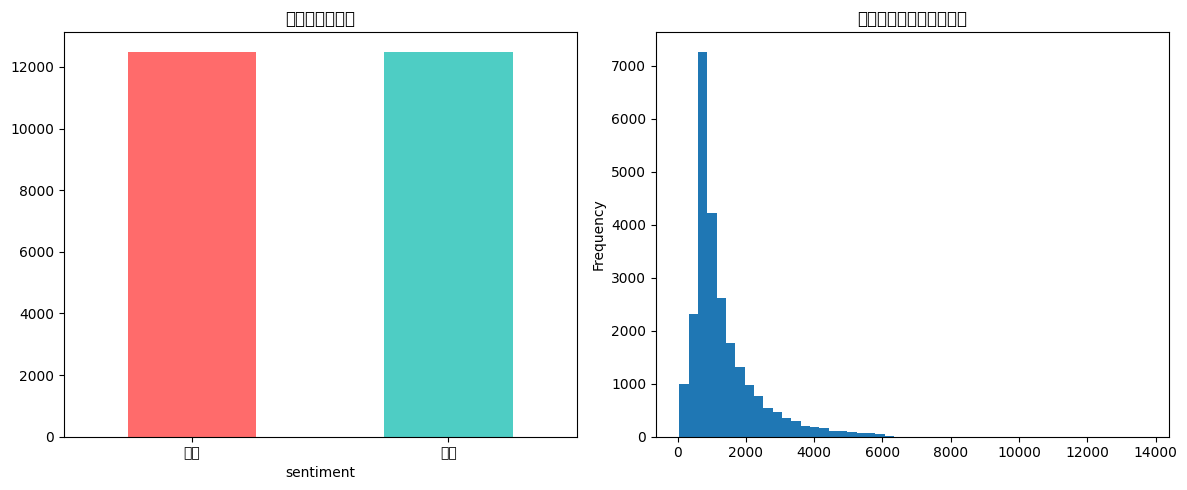


📝 训练集标签分布:
sentiment
1    12500
0    12500
Name: count, dtype: int64

📝 原始评论示例:
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want  ...


In [44]:
# ==================== 4. 数据可视化 ====================
print("\n📈 正在生成数据可视化...")
plt.figure(figsize=(12, 5))

# 子图1：正负面评论分布
plt.subplot(1, 2, 1)
train['sentiment'].value_counts().plot(
    kind='bar',
    color=['#FF6B6B', '#4ECDC4'],
    title='正负面评论分布'
)
plt.xticks([0, 1], ['负面', '正面'], rotation=0)

# 子图2：评论长度分布
plt.subplot(1, 2, 2)
train['review'].str.len().plot(
    kind='hist',
    bins=50,
    title='评论长度分布（字符数）'
)

plt.tight_layout()
plt.show()

print("\n📝 训练集标签分布:")
print(train['sentiment'].value_counts())
print("\n📝 原始评论示例:")
print(train['review'].iloc[0][:200], "...")

In [46]:
# ==================== 5. 文本预处理 ====================
print("\n🛠️ 开始文本预处理...")

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'<[^>]+>', ' ', text)  # 移除HTML标签
        text = re.sub(r'http\S+', ' ', text)  # 移除URL
        text = re.sub(r'[^\w\s]', ' ', text)  # 移除非字母数字字符
        text = re.sub(r'\d+', ' ', text)      # 移除数字
        return ' '.join(text.split())         # 合并多余空格
    
    def preprocess(self, text):
        cleaned = self.clean_text(text)
        tokens = [self.lemmatizer.lemmatize(w) for w in word_tokenize(cleaned) 
                 if w not in STOPWORDS and len(w) > 2]  # 移除停用词和短词
        return ' '.join(tokens)

preprocessor = TextPreprocessor()

# 显示预处理示例
print("\n🔧 预处理示例:")
print("   原始文本:", train['review'].iloc[0][:100], "...")
print("   清洗后:", preprocessor.clean_text(train['review'].iloc[0])[:100], "...")
print("   最终处理:", preprocessor.preprocess(train['review'].iloc[0])[:100], "...")

# 正式处理（带进度条）
print("\n⏳ 正在处理训练集（25,000条）...")
train['processed'] = train['review'].progress_apply(preprocessor.preprocess)
print("\n⏳ 正在处理测试集（25,000条）...")
test['processed'] = test['review'].progress_apply(preprocessor.preprocess)

print("\n✅ 预处理完成")
print("   处理后示例:", train['processed'].iloc[0][:100], "...")


🛠️ 开始文本预处理...

🔧 预处理示例:
   原始文本: "With all this stuff going down at the moment with MJ i've started listening to his music, watching  ...
   清洗后: with all this stuff going down at the moment with mj i ve started listening to his music watching th ...
   最终处理: stuff going moment started listening music watching odd documentary watched wiz watched moonwalker m ...

⏳ 正在处理训练集（25,000条）...


100%|██████████| 25000/25000 [00:33<00:00, 742.52it/s]



⏳ 正在处理测试集（25,000条）...


100%|██████████| 25000/25000 [00:32<00:00, 759.02it/s]


✅ 预处理完成
   处理后示例: stuff going moment started listening music watching odd documentary watched wiz watched moonwalker m ...


In [47]:
# ==================== 6. 模型训练 ====================
print("\n🤖 正在构建模型管道...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.7
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

print("\n🔧 模型配置:")
print("   - 特征数量: 10,000")
print("   - N-gram范围: (1, 2)")
print("   - 最小文档频率: 5")
print("   - 最大文档频率: 70%")
print("   - 逻辑回归:")
print("     * 最大迭代次数: 1000")
print("     * 类别权重: balanced")
print("     * 随机种子: 42")

print("\n⏳ 正在划分训练集/验证集...")
X_train, X_val, y_train, y_val = train_test_split(
    train['processed'], 
    train['sentiment'], 
    test_size=0.2, 
    random_state=42
)
print(f"   - 训练样本: {len(X_train)}")
print(f"   - 验证样本: {len(X_val)}")

print("\n⏳ 开始训练模型（可能需要几分钟）...")
pipeline.fit(X_train, y_train)
print("✅ 模型训练完成")


🤖 正在构建模型管道...

🔧 模型配置:
   - 特征数量: 10,000
   - N-gram范围: (1, 2)
   - 最小文档频率: 5
   - 最大文档频率: 70%
   - 逻辑回归:
     * 最大迭代次数: 1000
     * 类别权重: balanced
     * 随机种子: 42

⏳ 正在划分训练集/验证集...
   - 训练样本: 20000
   - 验证样本: 5000

⏳ 开始训练模型（可能需要几分钟）...
✅ 模型训练完成


In [48]:
# ==================== 7. 模型评估 ====================
print("\n📊 正在评估模型...")
val_pred = pipeline.predict(X_val)

print("\n📝 验证集性能:")
print(f"   准确率: {accuracy_score(y_val, val_pred):.4f}")

print("\n📋 详细分类报告:")
print(classification_report(y_val, val_pred, 
                          target_names=['负面', '正面'],
                          digits=4))


📊 正在评估模型...

📝 验证集性能:
   准确率: 0.8906

📋 详细分类报告:
              precision    recall  f1-score   support

          负面     0.8996    0.8775    0.8884      2481
          正面     0.8822    0.9035    0.8927      2519

    accuracy                         0.8906      5000
   macro avg     0.8909    0.8905    0.8906      5000
weighted avg     0.8908    0.8906    0.8906      5000




🔮 正在生成测试集预测...
   预测完成，正面评论比例: 50.28%


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

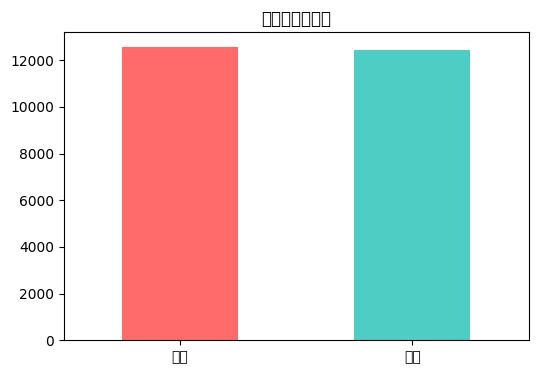

In [49]:
# ==================== 8. 生成预测 ====================
print("\n🔮 正在生成测试集预测...")
test_pred = pipeline.predict(test['processed'])
print(f"   预测完成，正面评论比例: {test_pred.mean():.2%}")

# 预测分布可视化
plt.figure(figsize=(6, 4))
pd.Series(test_pred).value_counts().plot(
    kind='bar',
    color=['#FF6B6B', '#4ECDC4'],
    title='测试集预测分布'
)
plt.xticks([0, 1], ['负面', '正面'], rotation=0)
plt.show()

In [50]:
# ==================== 9. 保存结果 ====================
print("\n💾 正在保存结果...")
submission = pd.DataFrame({
    'id': test['id'],
    'sentiment': test_pred
})
submission.to_csv("submission.csv", index=False)

print("✅ 结果已保存为 submission.csv")
print("   文件预览:")
print(submission.head())


💾 正在保存结果...
✅ 结果已保存为 submission.csv
   文件预览:
           id  sentiment
0  "12311_10"          1
1    "8348_2"          0
2    "5828_4"          1
3    "7186_2"          1
4   "12128_7"          1


In [51]:
# ==================== 10. 流程完成 ====================
print("\n" + "="*60)
print("🎉 分析流程完成！")
print("="*60)
print("最终结果已保存为 submission.csv")
print(f"验证集准确率: {accuracy_score(y_val, val_pred):.4f}")
print(f"测试集正面比例: {test_pred.mean():.2%}")


🎉 分析流程完成！
最终结果已保存为 submission.csv
验证集准确率: 0.8906
测试集正面比例: 50.28%
